In [1]:
from os import listdir
from os.path import isfile
from fnmatch import fnmatch
from math import isnan, ceil
from pprint import pprint
from statistics import median
from re import match, search

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.font_manager import FontProperties

In [2]:
def get_ratio(filename, mw=False):
    i = 0
    if mw:
        i = 1
    return filename.split('_')[i].replace('ratio','')

In [3]:
def get_run(filename, mw=False):
    i = 1
    if mw:
        i = 2
    return int(filename.split('_')[i].replace('run',''))

In [4]:
def get_vcs(filename, mw=False):
    i = 2
    if mw:
        i = 3
    return int(filename.split('_')[i].replace('vclients',''))

In [5]:
def get_worker_threads(filename, mw=False):
    i = 3
    if mw:
        i = 4 
        return int(filename.split('_')[i].replace('workerthreads', '').replace('.log', ''))
    return int(filename.split('_')[i].replace('workerthreads', ''))

In [6]:
def get_client(filename):
    return int(filename.split('_')[4].replace('client', ''))

In [7]:
def get_instance(filename):
    return int(filename.split('_')[-1].replace('instance','').replace('.log', ''))

In [8]:
def get_mw(filename):
    return int(filename.split('_')[0].replace('stats', ''))

In [9]:
def roundup(x):
    return int(ceil(x / 1.0)) * 1

In [10]:
def parse_line(line):
    ops_pat = '(\d+) \(avg:\s+\d+\) ops/sec,'
    ops = int(search(ops_pat, line).group(1))
    latency_pat = '(\d+\.\d+) \(avg:\s+\d+\.\d+\) msec latency'
    latency = float(search(latency_pat, line).group(1))
    return {'ops': ops, 'rt': latency}

In [11]:
def parse_content(path, filename):
    content = []
    with (open(path+filename, 'r')) as file:
        for line in file.readlines():
            if line.startswith('[RUN #1 ') and 'nan' not in line:
                content.append(parse_line(line))
    return content[10:60]

In [12]:
def dump_csv(df, filename):
    df.to_csv(filename, float_format='%.2f')
    return

In [13]:
def get_avg_rt(df, ratios, worker_threads, vclients, runs, threads, instances, clients):
    rts = []
    stds = []
    ils = []
    xs = [x * threads * instances * clients for x in vclients] 
    system = 'mt' if len(df.columns) < 3 else 'mw'
    
    for ratio in ratios:
        fig, ax = plt.subplots()
        whole = []
        whole_stds = [] 
        for wt in worker_threads:
            values = [.0] * len(vclients)
            std = [.0] * len(vclients)
            il = [.0] * len(vclients)
            for i, vc in enumerate(vclients):
                if system == 'mt':
                    values[i] = df.unstack().loc[(ratio, wt, vc), 'ResponseTime (ms)'].T.mean().unstack().T.mean().mean()
                    std[i] = np.std(df.unstack().loc[(ratio, wt, vc), 'ResponseTime (ms)'].T.mean().unstack().T.mean())
                    il[i] = (1 / values[i]) * 1000 * (vc * threads * instances * clients)
                else:
                    values[i] = df.loc[(ratio, wt, vc), 'ResponseTime (ms)'].unstack().T.mean().mean()
                    std[i] = np.std(df.loc[(ratio, wt, vc), 'ResponseTime (ms)'].unstack().T.mean().values.tolist())
                    # Little's Law for the number of jobs in the system
                    jobs =  df.loc[(ratio, wt, vc), 'Jobs'].unstack().T.mean().mean() / 70.0 / 1000 * df.loc[(ratio, wt, vc), 'ResponseTime (ms)'].unstack().T.mean().mean()
                    il[i] = (1 / values[i]) * 1000 * (jobs) * 2
                    
            plt.errorbar(xs , values, std, label='AVG of %d reps %d WTs' % (max(runs), wt), capsize=3)
            ax.set_xlim(xmin=0, xmax=max(xs))
            plt.xticks(xs)
            plt.xlabel('Virtual Clients')
            plt.ylabel('Response Time (msec)')
            fontP = FontProperties()
            fontP.set_size('small')
            plt.legend(loc='best', frameon=False)
            plt.grid(b=True, which='major', axis='both', color='0.6', linestyle='dotted')
            rts.append(values)    
            stds.append(std)
            ils.append(il)
            whole.append(values)
            whole_stds.append(std)
            
        if system == 'mt':
            title = 'MEMTIER'
        else:
            title = 'MIDDLEWARE'
        if ratio == '1:0':
            op = 'write-only'
        else:
            op = 'read-only'
            
        plt.title("%s %s" % (title, op))
        plt.ylim(0, np.max(whole) + np.amax(whole_stds))
        filename = ('rt_%s_%s' % (title, op)).lower()
        plt.savefig('img/%s.png' % filename, bbox_inches='tight')
        
    return rts, stds, ils

In [14]:
def get_avg_tp(df, ratios, worker_threads, vclients, runs, ils, threads, instances, clients):
    tps = []
    stds = []
    xs = [x * threads * instances * clients for x in vclients] 
    system = 'mt' if len(df.columns) < 3 else 'mw'
    l = 0
    
    for ratio in (ratios):
        fig, ax = plt.subplots()
        for j, wt in enumerate(worker_threads):
            values = [.0] * len(vclients)
            std = [.0] * len(vclients)
            for i, vc in enumerate(vclients):
                if system == 'mt':
                    values[i] = df.unstack().loc[(ratio, wt, vc), 'Throughput (ops/s)'].T.sum().unstack().T.sum().mean()
                    std[i] = np.std(df.unstack().loc[(ratio, wt, vc), 'Throughput (ops/s)'].T.sum().unstack().T.sum())
                else:
                    values[i] = df.unstack().loc[(ratio, wt, vc), 'Throughput (ops/s)'].T.sum().mean()
                    std[i] = np.std(df.unstack().loc[(ratio, wt, vc), 'Throughput (ops/s)'].T.sum().values.tolist())
                    
            plt.errorbar(xs, values, std, label='AVG of %d reps %d WTs' % (max(runs), wt), capsize=3)
            plt.plot(xs, ils[l], label='IL %d WTs' % wt, linestyle='--')
            ax.set_xlim(xmin=0, xmax=max(xs))
            plt.xticks(xs)
            plt.xlabel('Virtual Clients')
            plt.ylabel('Throughput (Ops/sec)')
            plt.legend(loc='best', frameon=False, ncol=2)
            plt.grid(b=True, which='major', axis='both', color='0.6', linestyle='dotted')
            k_formatter = lambda v, p: str(float(v / 1000)) + 'k'
            ax.yaxis.set_major_formatter(ticker.FuncFormatter(k_formatter))
            tps.append(values)
            stds.append(std)
            l+=1
            
        if system == 'mt':
            title = 'MEMTIER'
        else:
            title = 'MIDDLEWARE'
        if ratio == '1:0':
            op = 'write-only'
        else:
            op = 'read-only'
            
        plt.title("%s %s" % (title, op))
        plt.ylim(0, 19000)
        filename = ('tp_%s_%s' % (title, op)).lower()
        plt.savefig('img/%s.png' % filename, bbox_inches='tight')
        
    return tps, stds

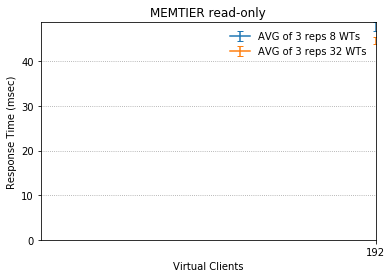

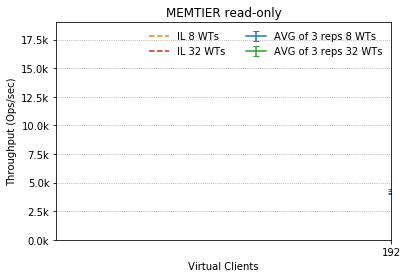

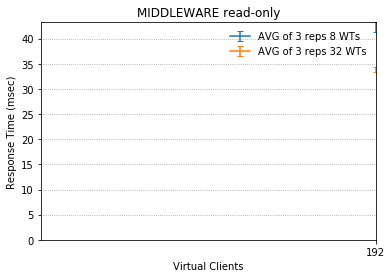

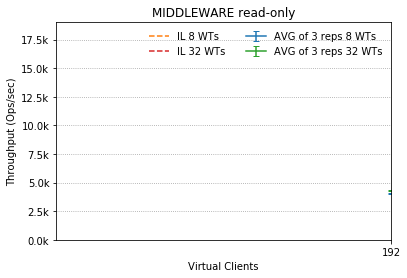

In [16]:
timestamp = '20181210011903'
log_dir = 'logs/%s/' % timestamp

logs = [f for f in listdir(log_dir) if fnmatch(f, '*.log')]

m = '^ratio(.*)'
memtier_logs = [f for f in logs if match(m, f)]
mw = '^stats(.*)'
middleware_logs = [f for f in logs if match(mw, f)]

ratios = ['0:1']
runs = [x for x in range(1, 3 + 1)] 
instances = [x for x in range(1, 2 + 1)]
threads = 1 
clients = [x for x in range(1, 3 + 1)]
vclients = [32]
worker_threads = [8, 32]
mws = [x for x in range(1, 2 + 1)]

mt_multi_index = [ratios, worker_threads, vclients, runs, clients, instances]
mw_multi_index = [ratios, worker_threads, vclients, runs, mws]

mt_len_index = len(ratios) * len(worker_threads) * len(vclients) * len(runs) * len(clients) * len(instances)
mw_len_index = len(mws) * len(ratios) * len(worker_threads) * len(vclients) * len(runs)

mt_names=['ratio', 'WTS', 'VCs', 'run', 'client', 'instance']
mw_names=['ratio', 'WTS', 'VCs', 'run', 'mw']

mt_index = pd.MultiIndex.from_product(mt_multi_index, names=mt_names)
mw_index = pd.MultiIndex.from_product(mw_multi_index, names=mw_names)
columns = ['Throughput (ops/s)', 'ResponseTime (ms)']
pd.set_option("display.precision", 2)

mt_template = pd.DataFrame([[.0] * len(columns)] * mt_len_index, index=mt_index, columns=columns)
columns += ['Jobs', 'ServiceTime (ms)', 'WaitingTime (ms)', 'QueueSize']
mw_template = pd.DataFrame([[.0] * len(columns)] * mw_len_index, index=mw_index, columns=columns)

for log_file in memtier_logs: 

    ratio = get_ratio(log_file) 
    run = get_run(log_file)
    vcs = get_vcs(log_file)
    client = get_client(log_file)
    instance = get_instance(log_file)
    wts = get_worker_threads(log_file)

    content = parse_content(log_dir, log_file)
    
    avg_tp = sum(d['ops'] for d in content) / len(content)
    avg_rt = sum(d['rt'] for d in content) / len(content)
   
    mt_template.loc[(ratio, wts, vcs, run, client, instance), 'Throughput (ops/s)'] = avg_tp
    mt_template.loc[(ratio, wts, vcs, run, client, instance), 'ResponseTime (ms)'] = avg_rt
    
for log_file in middleware_logs:
    ratio = get_ratio(log_file, True) 
    run = get_run(log_file, True)
    vcs = get_vcs(log_file, True)
    wts = get_worker_threads(log_file, True)
    mw = get_mw(log_file)

    with (open(log_dir+log_file, 'r')) as file:
        lines = file.readlines()

        offset = -1
        for i, line in enumerate(lines):
            if "Interval" in line:
                offset = i

        table = pd.read_table(log_dir+log_file, skiprows=1, engine='python', nrows=offset-1, skipinitialspace=True, sep=',\s*', index_col=0, names=['Elapsed Time', 'AVG Throughput', 'AVG Queue Size', 'AVG Waiting Time', 'AVG Service Time', 'AVG Response Time', 'AVG SET Response Time', 'AVG GET Response Time', 'AVG MULTI-GET Response Time', '#SETS', '#GETS', '#MULTIGETS', 'GET MissRatio', 'MULTI-GET MissRatio', 'AVG MULTI-GET Size'])
        table = table.astype('float32')
        
        sets = table['#SETS'].sum()
        gets = table['#GETS'].sum()
        multi = table['#MULTIGETS'].sum()
        
        mw_template.loc[(ratio, wts, vcs, run, mw), 'Throughput (ops/s)'] = table['AVG Throughput'].values[1:-1].mean()
        mw_template.loc[(ratio, wts, vcs, run, mw), 'ResponseTime (ms)'] = table['AVG Response Time'].values[1:-1].mean()
        if ratio == '1:0':
            mw_template.loc[(ratio, wts, vcs, run, mw), 'Jobs'] = table['#SETS'].sum()
        else:
            mw_template.loc[(ratio, wts, vcs, run, mw), 'Jobs'] = table['#GETS'].sum()
        mw_template.loc[(ratio, wts, vcs, run, mw), 'ServiceTime (ms)'] = table['AVG Service Time'].values[1:-1].mean()
        mw_template.loc[(ratio, wts, vcs, run, mw), 'WaitingTime (ms)'] = table['AVG Waiting Time'].values[1:-1].mean()
        mw_template.loc[(ratio, wts, vcs, run, mw), 'QueueSize'] = table['AVG Queue Size'].values[1:-1].mean()
        
rts, stds, ils = get_avg_rt(mt_template, ratios, worker_threads, vclients, runs, threads, len(instances), len(clients))
tps, stds = get_avg_tp(mt_template, ratios, worker_threads, vclients, runs, ils, threads, len(instances), len(clients))

dump_csv(mt_template, 'out/memtier_data.csv')
ils =[]

rts, stds, ils = get_avg_rt(mw_template, ratios, worker_threads, vclients, runs, threads, len(instances), len(clients))
tps, stds = get_avg_tp(mw_template, ratios, worker_threads, vclients, runs, ils, threads, len(instances), len(clients))

dump_csv(mw_template, 'out/middleware_data.csv')